# reprodução eficaz em Santa Catarina

Esta é uma cópia e adaptação do [realtime_r0_brazil da loft](https://github.com/loft-br/realtime_r0_brazil) adaptado para o estado de Santa Catarina.


## disclaimer

Este trabalho ainda é experimental, e está em construção.

In [1]:
# importing core 
# aqui empacotamos as funções que dá pra achar no código do Kevin Systrom
from core import run_full_model, plot_rt, plot_standings

# imports básicos
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# importando joblib para rodar em paralelo
from joblib import Parallel, delayed

# para plots com uma melhor resolução
%config InlineBackend.figure_format = 'retina'

Área reservada para parâmetros do modelo. Até agora só deixamos aberto N_JOBS, para escolher o número de núvleos para o ajuste dos modelos.

In [2]:
### parâmetros ###

# númereo de cores para paralelizar modelo nos estados
N_JOBS = -1

## Leitura dos dados

Usamos o [repositório do Wesley Cota](https://github.com/wcota/covid19br) para pegar os dados mais atualizados por estado.

In [3]:
dataSourceURL = 'https://raw.githubusercontent.com/wcota/covid19br/master/cases-brazil-cities-time.csv'

sc_top_cities_df = (
    pd.read_csv(dataSourceURL, parse_dates=['date'])
    .rename(columns={'totalCases':'confirmed_total',
                     'newCases': 'confirmed_new',
                     'deaths': 'deaths_total',
                     'newDeaths': 'deaths_new'})
    .query('state == "SC"')
    .drop(['ibgeID','country','state'], axis=1)
)

# iremos filtrar apenas pelas cidades com maior numero de casos no ( apurados no final de abril)
#top_cities_filter = ['Florianópolis/SC', 'Blumenau/SC', 'Joinville/SC', 'Balneário Camboriú/SC', 'Camboriú/SC', 'Criciúma/SC']
top_cities_filter = ['Florianópolis/SC', 'Blumenau/SC', 'Joinville/SC', 'Camboriú/SC', 'Criciúma/SC', 'Itajaí/SC' ]

sc_top_cities_df = sc_top_cities_df[sc_top_cities_df['city'].isin(top_cities_filter)]
sc_top_cities_df = sc_top_cities_df.groupby(['city','date']).sum()


# para a análise, vamos usar somente novos casos confirmados
sc_top_cities_df = sc_top_cities_df['confirmed_new']

# listando os municipios
#for grp in sc_top_cities_df.groupby(level='city'):
#    print(grp)

## Ajuste do modelo

In [4]:
### running posteriors ###
with Parallel(n_jobs=N_JOBS) as parallel:
    results = parallel(delayed(run_full_model)(grp[1], sigma=0.01) for grp in sc_top_cities_df.groupby(level='city'))

final_results = pd.concat(results)

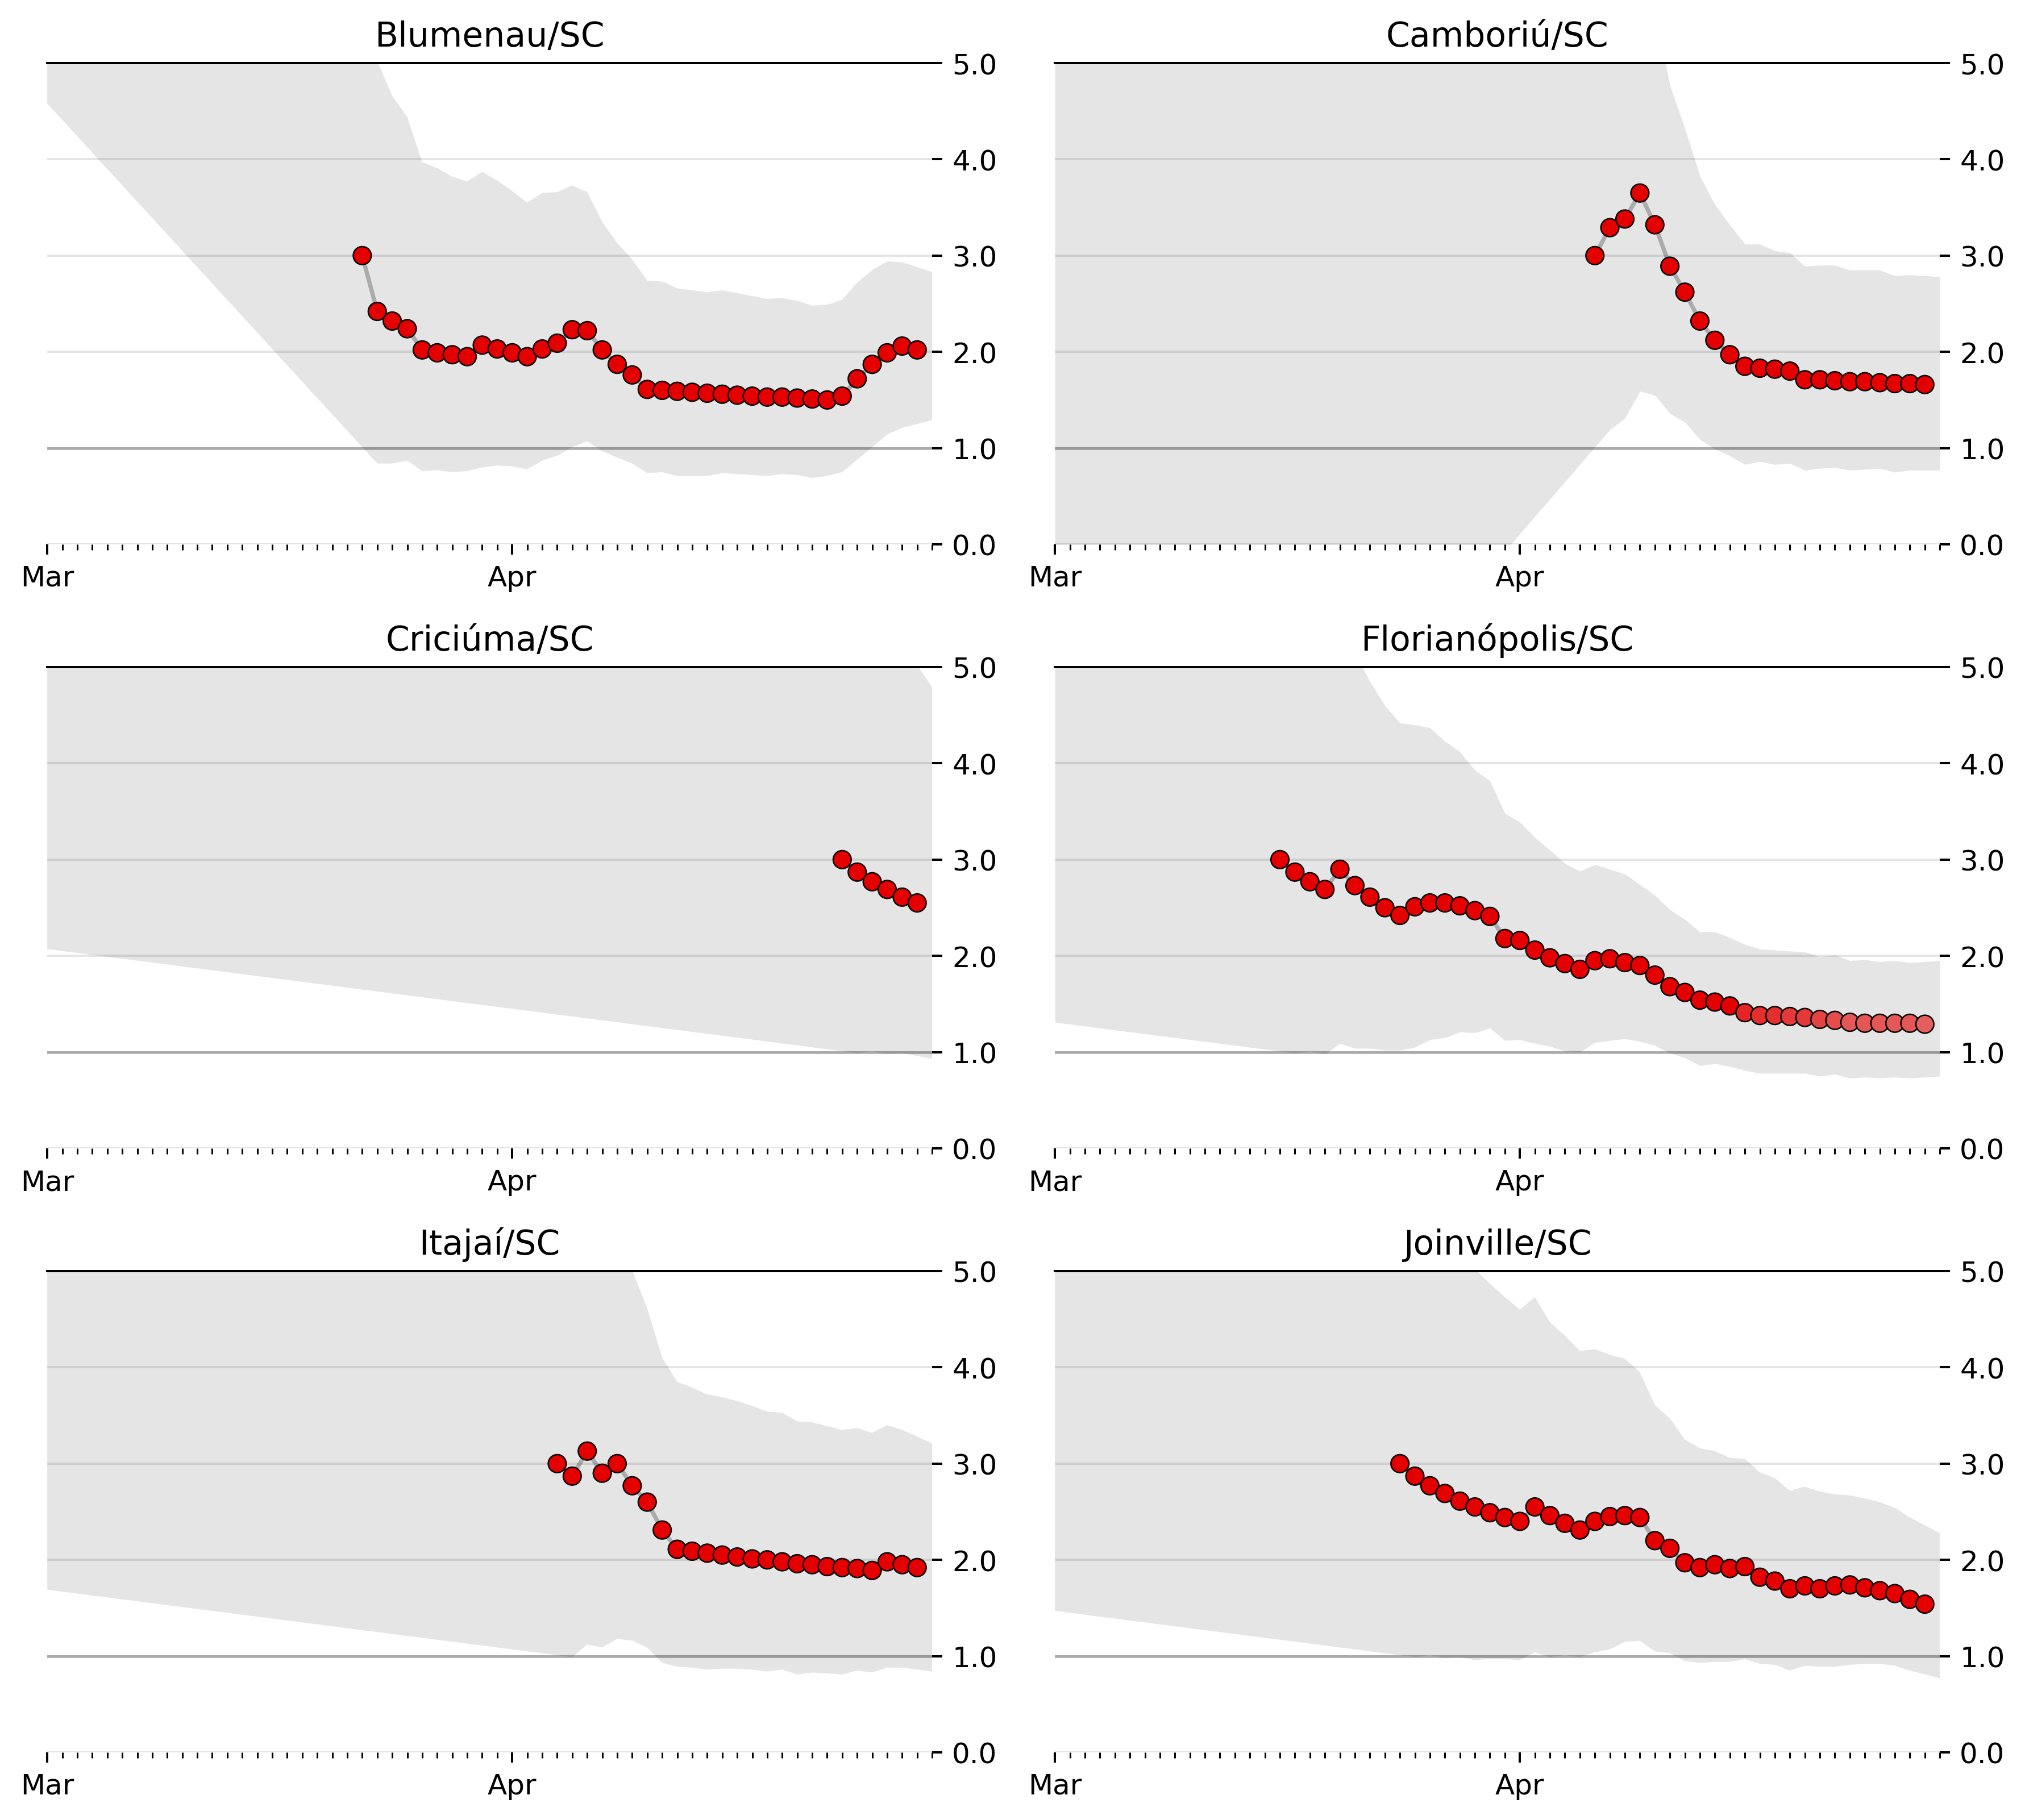

In [5]:
### plotting - Rt vs time for all states ###

def plot_rt_states():

    # number of columns and rows for plotting
    N_COLS = 2
    N_ROWS = int(np.ceil(len(results) / N_COLS))

    # opening figura
    fig, axes = plt.subplots(nrows=N_ROWS, ncols=N_COLS, figsize=(10, N_ROWS*3), dpi=180)

    # loop for several states
    for i, (state_name, result) in enumerate(final_results.groupby('city')):
        plot_rt(result, axes.flat[i], state_name)

    # saving figure
    fig.tight_layout()
    fig.set_facecolor('w')

plot_rt_states()

## Observando os resultados: comparação entre estados

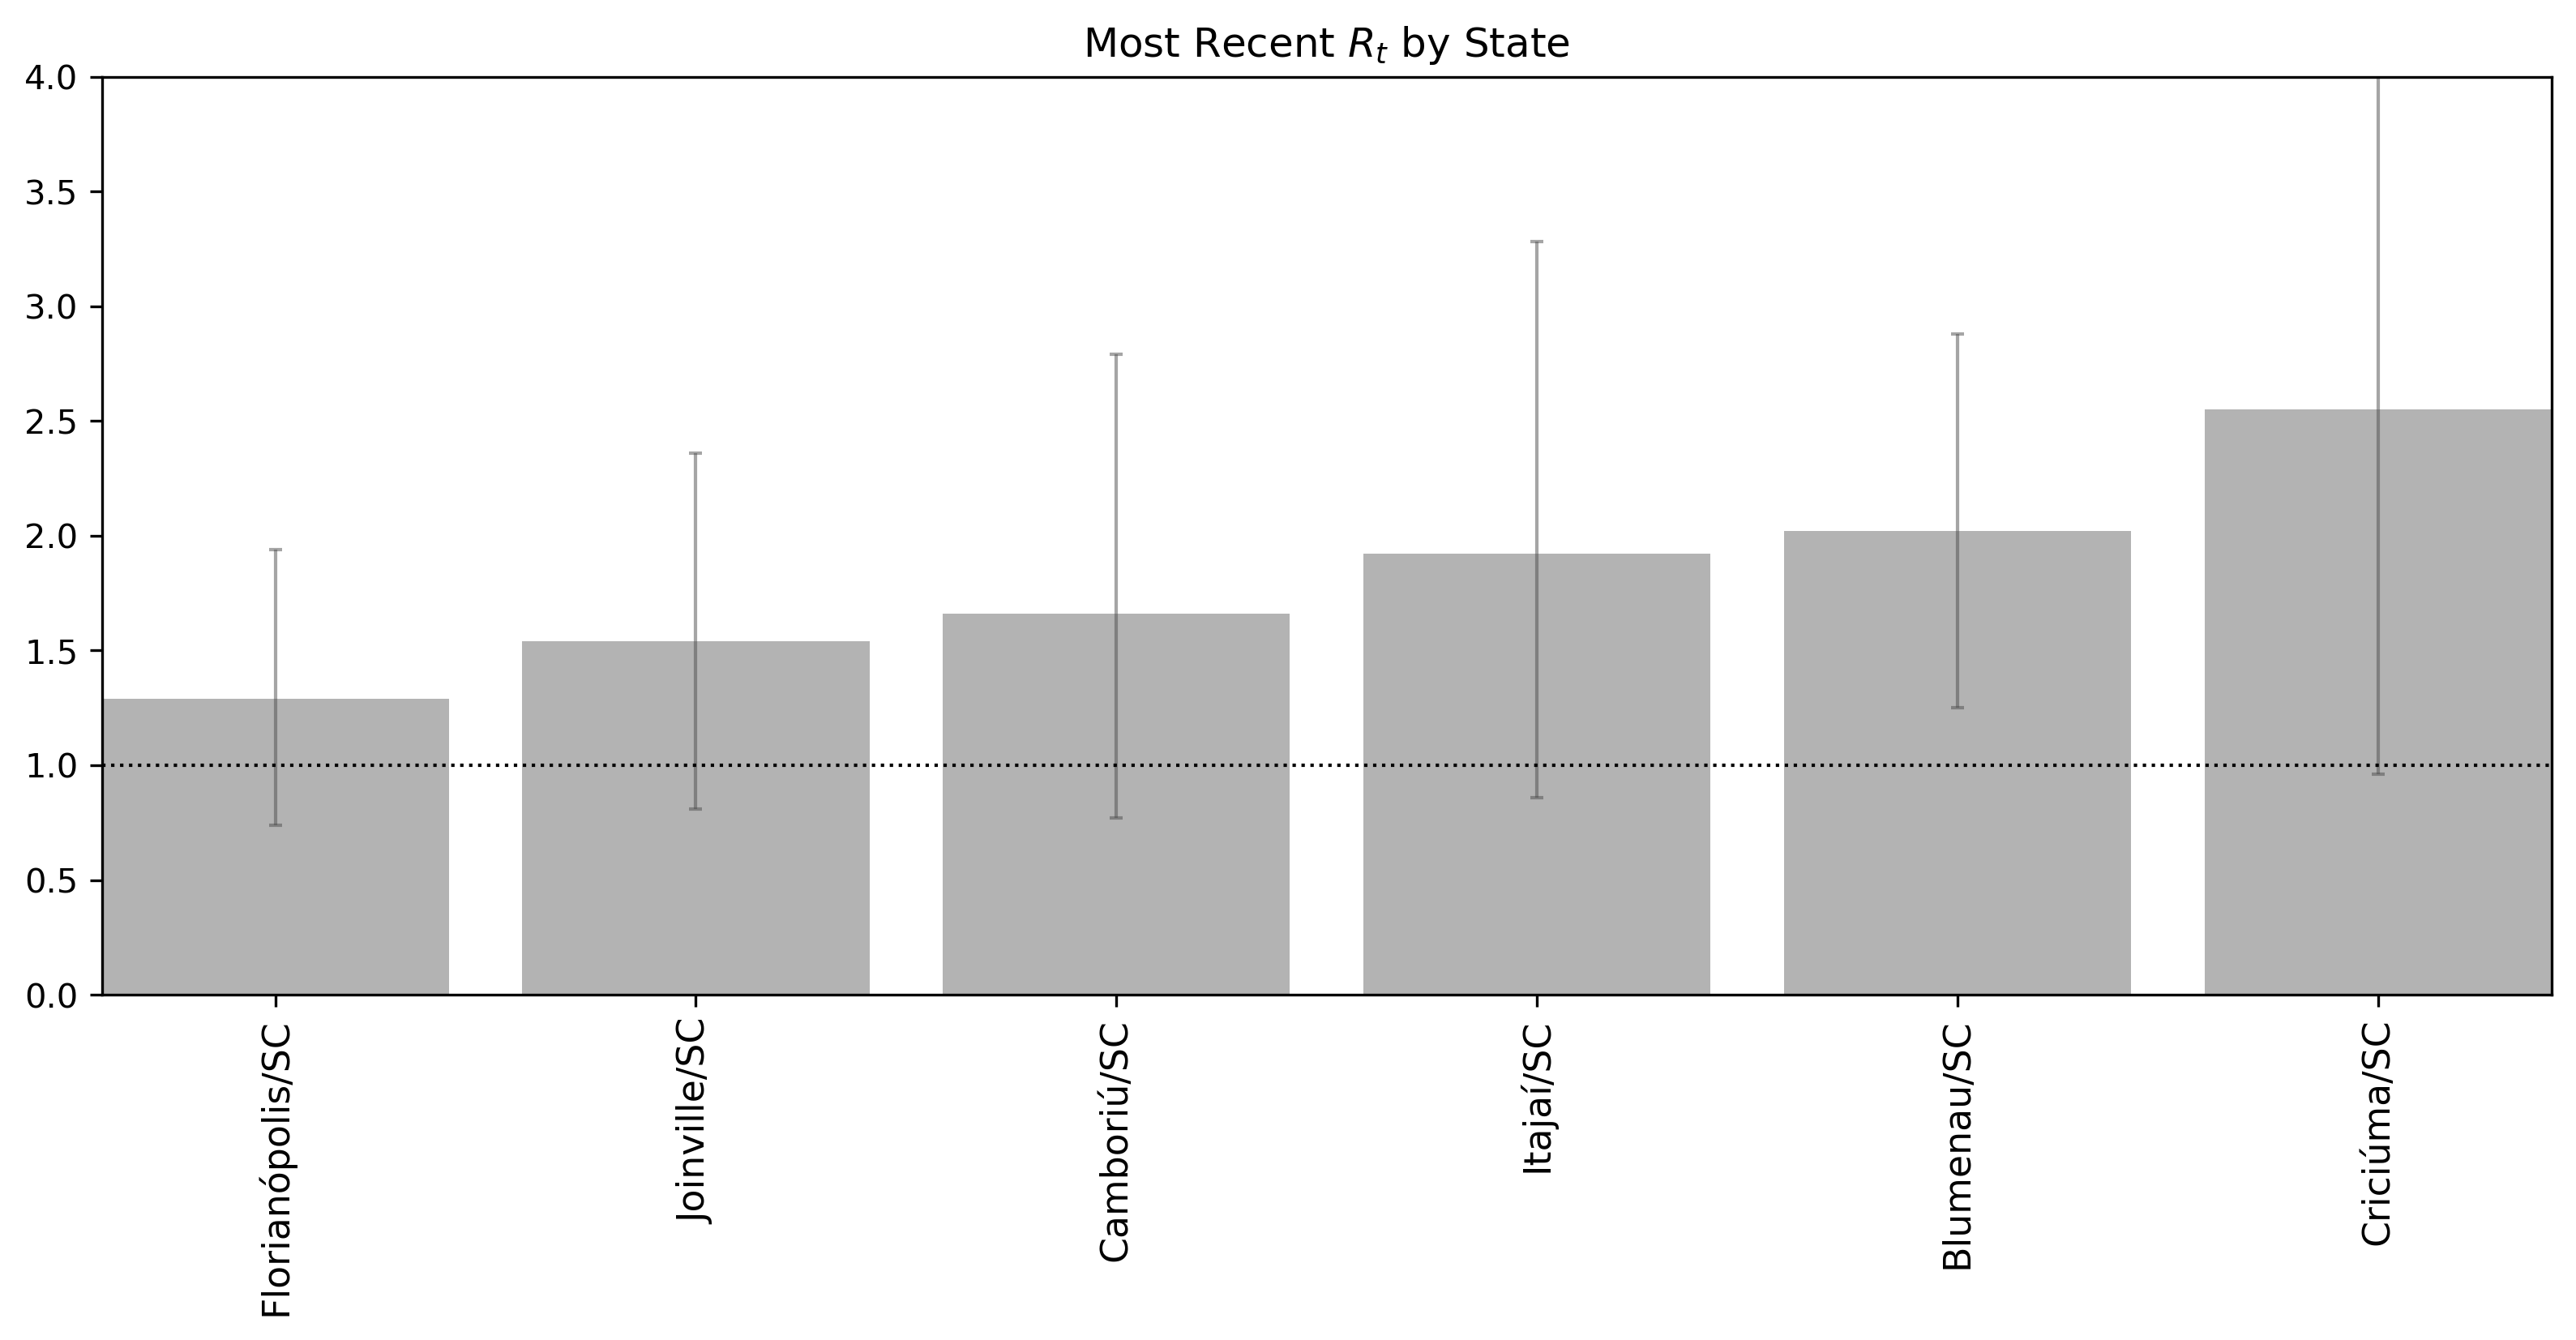

In [6]:
### plotting - state comparison ###

mr = final_results.groupby(level=0)[['ML', 'High_90', 'Low_90']].last()
mr.sort_values('ML', inplace=True)
plot_standings(mr, figsize=(13,5));